In [1]:
# Import used packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import random
import keras
import sklearn

import datetime

In [2]:
## Read in the data set kepping date as index
df=pd.read_csv('weighted_sum.csv')
df

,date,weighted_sum
0,2019-10-24,129.124763
1,2019-10-25,397.525094
2,2019-10-26,179.953536
3,2019-10-27,19.276294
4,2019-10-28,614.867925
...,...,...
1486,2023-12-02,114.049422
1487,2023-12-03,0.000000
1488,2023-12-04,226.893157
1489,2023-12-05,390.659238


In [3]:
#rename date column to time as days
df.rename(columns={'date': 'time'}, inplace=True)
# make the 'date' column as index of the DataFrame, replacing the default numerical index.
df.index = df['time']
#Drop the column labeled as date
df.drop(columns='time', axis=1, inplace=True)
df

,weighted_sum
time,
2019-10-24,129.124763
2019-10-25,397.525094
2019-10-26,179.953536
2019-10-27,19.276294
2019-10-28,614.867925
...,...
2023-12-02,114.049422
2023-12-03,0.000000
2023-12-04,226.893157


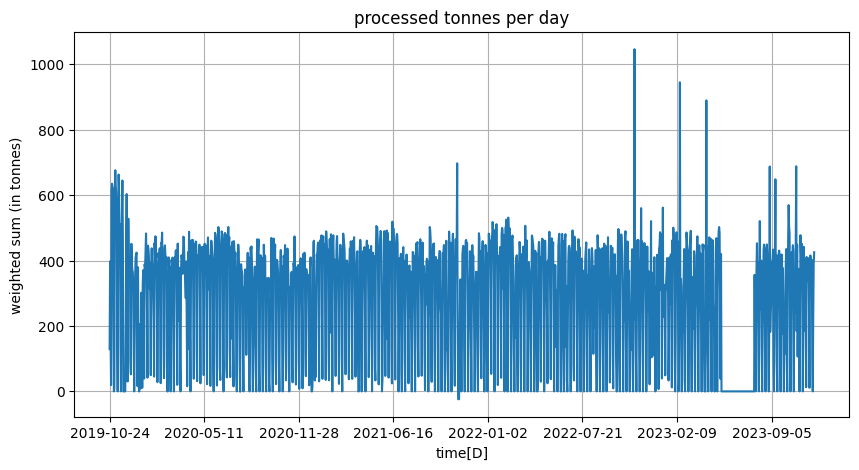

In [4]:
# plotting a line plot after changing it's width and height
def plot_ts(df, xlabel='time[D]', ylabel='weighted sum (in tonnes)', title='processed tonnes per day', figsize=(10,5), grid=True, legend=False):
    df['weighted_sum'].plot(xlabel=xlabel, ylabel=ylabel, title=title, figsize=figsize, grid=grid, legend=legend)
    plt.show()
   

# visualize
plot_ts(df)

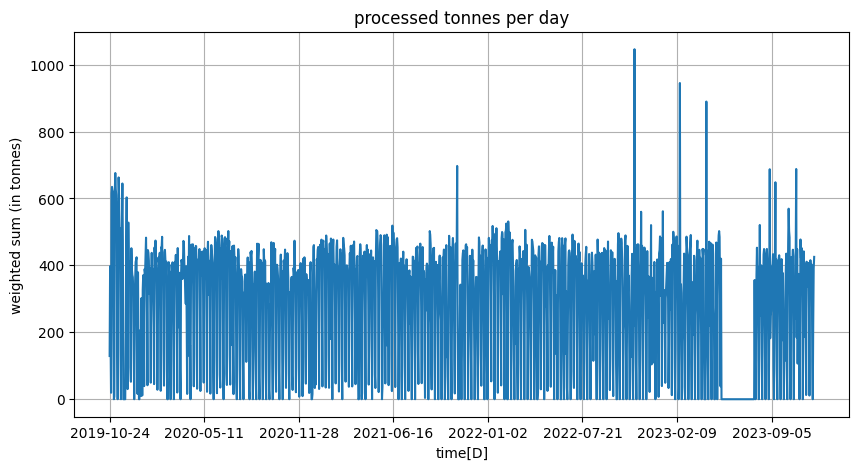

In [9]:
# Remove negative value in order to correctly scale
df['weighted_sum'] = df['weighted_sum'].clip(lower=0)
# visualize
plot_ts(df)

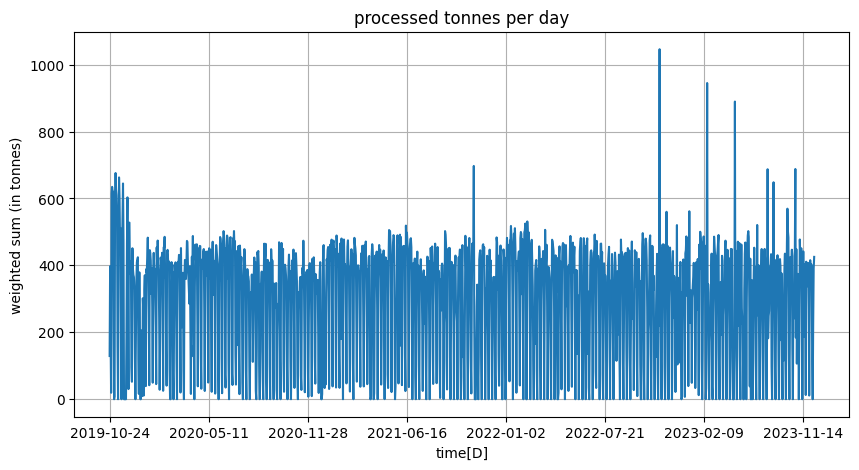

In [11]:
# Visualise the data without the missing values in summer 2023
plot_ts(pd.concat([df[:'2023-05-16'], df['2023-07-27':]]))

## The Augmented Dickey-Fuller test to check stationarity


The Augmented Dickey-Fuller test
Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.



In [18]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['weighted_sum'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')            
for key, value in result[4].items(): #  iterates over these critical values, result=4, contains critical values for different significance levels of the ADF test
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -4.051331
p-value: 0.001164
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


The p-value obtained is less than the significance level of 0.05, and the ADF statistic is lower than any of the critical values. Clearly, the null hypothesis is rejected. So, the time series stationary.

The ADF test statistic value of -4. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4 is less than the value of -3.449 at 1% and also for others.

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure



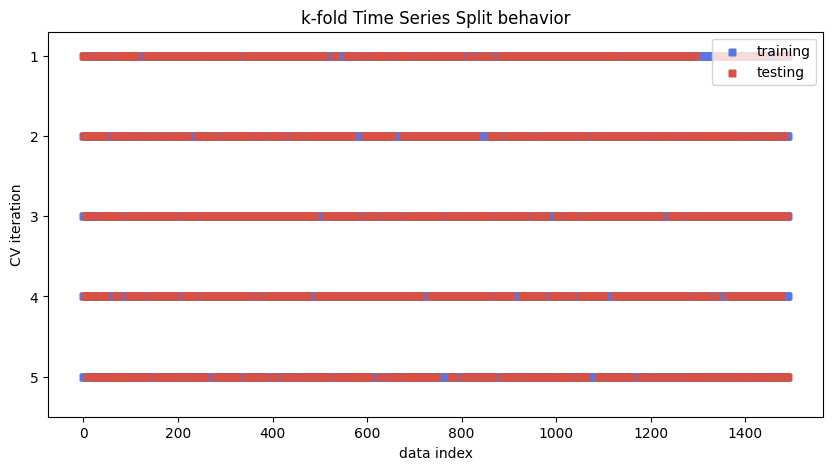

In [21]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# here we keep shuffle=True to randomize the splits
kf = KFold(n_splits=5, shuffle=True, random_state=40)  

fig, ax= plt.subplots(figsize=(10,5))

for i, (train_index, test_index) in enumerate(kf.split(df), start=1):
    train_data = df.iloc[train_index].values
    test_data = df.iloc[test_index].values
    
    #print(f"Fold {i}:")
    #print(f"  Train: index={train_index}")
    #print(f"  Test:  index={test_index}")
   
    #plot training and test indices
    l1=ax.scatter(train_index,[i]*len(train_index), c=[plt.cm.coolwarm(.1)],
                  marker= '+', lw=5)
    l2=ax.scatter(test_index,[i]*len(test_index), c=[plt.cm.coolwarm(.9)],
                  marker='+', lw=5)
    ax.set(ylim=[5.5, 0.7], title='k-fold Time Series Split behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1,l2],['training', 'testing'])
  

#### Transform Time Series to Supervised Learning problem : 
The LSTM model in Keras assumes that data is divided into input (X) and output (y) components. For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

In [58]:
# first define a function for the number of previous time steps to use for predicting the next time step.
from pandas import concat    

def ts_to_supervised(df, time_step=1):
    cols = [df.shift(i) for i in range(1, time_step + 1)]
    cols.append(df)
    data = pd.concat(cols,axis=1)
    data.fillna(0, inplace=True)
    
    # Rename columns to indicate time steps
    col_names = [f't-{i}' for i in range(1,time_step+1)] + ['t']
    data.columns = col_names # Assign column names
    return data

# transform to supervised learning
supervised = ts_to_supervised(df, time_step=2)
print(supervised.head(20))
    

                   t-1         t-2           t
time                                          
2019-10-24    0.000000    0.000000  129.124763
2019-10-25  129.124763    0.000000  397.525094
2019-10-26  397.525094  129.124763  179.953536
2019-10-27  179.953536  397.525094   19.276294
2019-10-28   19.276294  179.953536  614.867925
2019-10-29  614.867925   19.276294  634.526163
2019-10-30  634.526163  614.867925  622.920089
2019-10-31  622.920089  634.526163  620.701784
2019-11-01  620.701784  622.920089  217.900209
2019-11-02  217.900209  620.701784    0.000000
2019-11-03    0.000000  217.900209    8.329495
2019-11-04    8.329495    0.000000  623.825204
2019-11-05  623.825204    8.329495  675.961407
2019-11-06  675.961407  623.825204  627.127364
2019-11-07  627.127364  675.961407  609.668061
2019-11-08  609.668061  627.127364  537.310311
2019-11-09  537.310311  609.668061  158.531217
2019-11-10  158.531217  537.310311    0.000000
2019-11-11    0.000000  158.531217  428.838854
2019-11-12  4

In [15]:
from sklearn.preprocessing import MinMaxScaler

# define a function to scale the original values to the scale of the used activation function
def scale_to_activation( train_data, test_data, activation_fun='tanh', feature_range=None ):
    
    if activation_fun =='tanh':         # default activation function for LSTMs is the hyperbolic tangent (tanh[-1,1])
        scaler = MinMaxScaler(feature_range=(-1, 1))
    elif activation_fun =='sigmoid':
        scaler = MinMaxScaler(feature_range(0, 1))
    else:
        scaler = MinMaxScaler(feature_range=feature_range)
    
    scaler=scaler.fit(train_data)
    
    train_data=train_data.reshape(train_data.shape[0],train_data.shape[1]) # it requires data provided in a matrix format with rows and columns. Therefore, must reshape NumPy arrays before transforming.
    train_data_scaled = scaler.transform(train_data)

    test_data=test_data.reshape(test_data.shape[0],test_data.shape[1])
    test_data_scaled = scaler.transform(test_data)

    return(scaler, train_data_scaled, test_data_scaled)

In [28]:
# Scale the data using 'tanh' activation function
scaler, train_data_scaled, test_data_scaled = scale_to_activation(train_data, test_data, activation_fun='tanh', feature_range=None)

# Print the scaled data
print("Scaler Feature Range:", scaler.feature_range)

print("Train data dimension", train_data_scaled.shape)
print("Scaled Train Data:\n", train_data_scaled)

print("Test data dimension", test_data_scaled.shape)
print("Scaled Test Data:\n", test_data_scaled)


Scaler Feature Range: (-1, 1)
Train data dimension (1193, 1)
Scaled Train Data:
 [[-0.75307581]
 [-0.23981613]
 [-0.65587638]
 ...
 [-0.20554048]
 [-1.        ]
 [-0.56611414]]
Test data dimension (298, 1)
Scaled Test Data:
 [[ 0.18696277]
 [-1.        ]
 [-0.10726483]
 [-1.        ]
 [-1.        ]
 [ 0.00917438]
 [-1.        ]
 [-0.21624902]
 [-0.1888625 ]
 [-0.7673011 ]
 [-0.96957269]
 [-0.27472777]
 [-0.68774998]
 [-0.42308679]
 [-0.97868693]
 [-0.92498711]
 [-0.1866695 ]
 [-0.92007267]
 [-0.20859117]
 [-0.9054813 ]
 [-0.25060074]
 [-0.16367551]
 [-0.91356843]
 [-0.27917057]
 [-0.199434  ]
 [-0.92240761]
 [-0.1464705 ]
 [-1.        ]
 [-0.39719019]
 [-0.27063248]
 [-0.61261174]
 [-0.23121881]
 [-0.25545489]
 [-0.21504563]
 [-0.09525882]
 [-0.37702054]
 [-0.24010867]
 [-0.36212646]
 [-0.92607992]
 [-0.16371524]
 [-0.74472312]
 [-0.2520936 ]
 [-0.13717792]
 [-0.55073056]
 [-0.95756436]
 [-0.17035303]
 [-0.10012634]
 [-0.40376807]
 [-0.20913246]
 [-0.78180039]
 [-0.08401911]
 [-0.76097

In [23]:
# Given values
a = 298
b = 1491

# Solve for x
x = (a / b) * 100

# Print the result
print(f"x = {x}%")


x = 19.98658618376928%


In [30]:
# A function to scale the scaled values back to the original scale
def scale_to_original(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1] # return first row last column value


In [279]:
def prepare_data(df, train_inds, test_inds, pred_win_size, activation_fun_lstm, num_features, feature_range):

    # MAKE TIME SERIES STATIONARY

    X = ts_to_supervised(df, time_step=pred_win_size)

    # Select training and testing data based on indices.
    # specify which rows of the dataset belong to the training set and which belong to the testing set for each fold of the cross-validation.
    train_data = X.iloc[train_inds[1:], :].values
    test_data = X.iloc[test_inds[:-1], :].values

    scaler, train_data_scaled, test_data_scaled = scale_to_activation(train_data=train_data, test_data=test_data,
                                                                      activation_fun=activation_fun_lstm, feature_range=feature_range)

                                                                         
    ## Prepare training and testing data.
    X_train = train_data_scaled[:-pred_win_size] # Exclude the last pred_win_size elements
    X_test = test_data_scaled[:-pred_win_size]

    # Reshape input data for LSTM
    X_train = X_train.reshape(X_train.shape[0], pred_win_size+1, num_features)
    X_test = X_test.reshape(X_test.shape[0], pred_win_size+1, num_features)

    y_train = train_data_scaled[pred_win_size:, -1]
    y_test = test_data_scaled[pred_win_size:, -1]

    return scaler, X_train, y_train, X_test, y_test



In [281]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def define_model(input_shape, num_layers, num_neurons, dropout_rate):
    
    model = Sequential()

    # Define the shape of the input
    model.add(keras.Input(shape=input_shape))

    # Stack num_layers - 1 LSTM layers on top of each other.
    # return_sequences must be set to True in order to make the output of the previous LSTM layer compatible with the input to the current LSTM layer
    
    for _ in range(num_layers - 1):
        model.add(LSTM(num_neurons, return_sequences=True, dropout=dropout_rate))

    # The last LSTM layer needs to have return_sequences to False (default) in order to be compatible with the output layer
    model.add(LSTM(num_neurons))
    
    # Get the output (which is just 1 number)
    model.add(Dense(1))

    return model

In [283]:
def compile_model(model, loss, learning_rate, metric):
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])

    return model

In [285]:
def fit_model(model, X, y, batch_size, metric, min_delta_es, patience_es, num_epochs, perc_val):

    callback = keras.callbacks.EarlyStopping(monitor=metric, min_delta = min_delta_es, patience = patience_es)
    
    history = model.fit(X, y, batch_size=batch_size, epochs=num_epochs, callbacks=[callback], validation_split=perc_val, shuffle=False, verbose=False)
    
    return model, history

In [287]:
def evaluate_model(model, X, y, metric):
    
    # Get the given metric from the sklearn.metrics package (since the metric is given as a string)
    fun = getattr(sklearn.metrics, metric)

    return fun(y, model.predict(X))

In [289]:
from pathlib import Path
import tensorflow as tf
import os
import random
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold



def train_and_evaluate_model(df,
                             n_splits_cv = 5,
                             
                             num_layers_lstm = 2,
                             num_neurons_lstm = 50,
                             dropout_rate = 0.2,
                             num_features = 1,
                            
                            
                             num_epochs = 50,
                             batch_size = 32,
                            
                             
                             min_delta_es = 0.01,
                             patience_es = 5,
                             pred_win_size = 7,
                             
                             activation_fun_lstm = 'tanh',
                             feature_range = None,
                            
                             loss = 'mean_squared_error',
                             metric = 'root_mean_squared_error',
                             learning_rate = 0.001,
                             perc_val = 0.2):

    # Set a seed to avoid different results due to randomization
    random.seed(1234)
    

    # 5 fold  cross validation
    kf = KFold(n_splits=n_splits_cv, shuffle=True, random_state=40)
    
    # Initialize list to store RMSE values for each fold
    rmse_scores = []
    
    # Initialize list to store training history for each fold
    training_histories = []
    
    # Train and evaluate a model for each fold of the K fold cross validation
    for fold_idx, (train_inds, test_inds) in enumerate(kf.split(df), start=1):

        scaler, X_train, y_train, X_test, y_test = prepare_data(df, train_inds=train_inds, test_inds=test_inds, pred_win_size=pred_win_size,
                                                                activation_fun_lstm=activation_fun_lstm, num_features=num_features, feature_range=feature_range)

        model = define_model(X_train.shape[1:], num_layers=num_layers_lstm, num_neurons=num_neurons_lstm, dropout_rate=dropout_rate)

        model = compile_model(model, loss=loss, learning_rate=learning_rate, metric=metric)

        model, history = fit_model(model, X=X_train, y=y_train, batch_size=batch_size,
                                   metric=metric, min_delta_es=min_delta_es, patience_es=patience_es,
                                   num_epochs=num_epochs, perc_val=perc_val)
        
        training_histories.append(history)

        rmse = evaluate_model(model, X_test, y_test, metric)

        # append rmse score to the list serially 
        rmse_scores.append(rmse) 
        print(f"Fold {fold_idx} RMSE: {rmse}")

        # Assuming y_test contains the actual values and y_pred contains the predicted values
        # Plot the actual values
        plt.plot(y_test, label='Actual')

        # Plot the predicted values
        plt.plot(model.predict(X_test), label='Predicted')

        # Add labels and title
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Actual vs. Predicted Values')
        plt.legend()

        # Show plot
        plt.show()
    
    # Compute and print the average RMSE across all folds
    avg_rmse = np.mean(rmse_scores)
    print(f"Average RMSE across all folds: {avg_rmse}")
    
    
    return avg_rmse, rmse_scores, training_histories

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Fold 1 RMSE: 0.38787055717674757
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


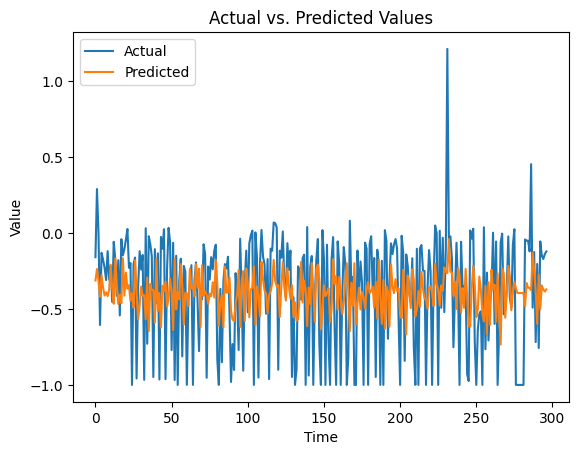

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 2 RMSE: 0.3605100916920926
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


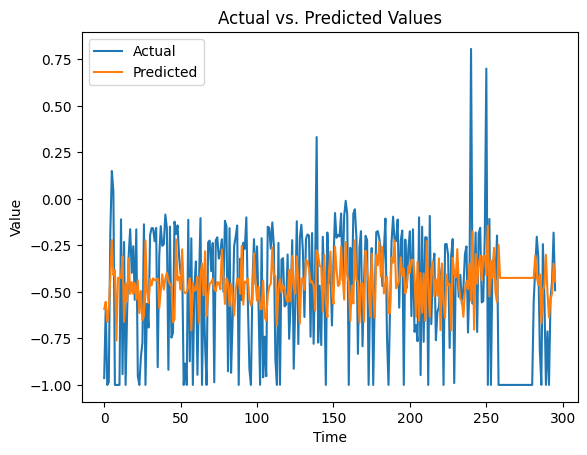

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 3 RMSE: 0.3456285645820192
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


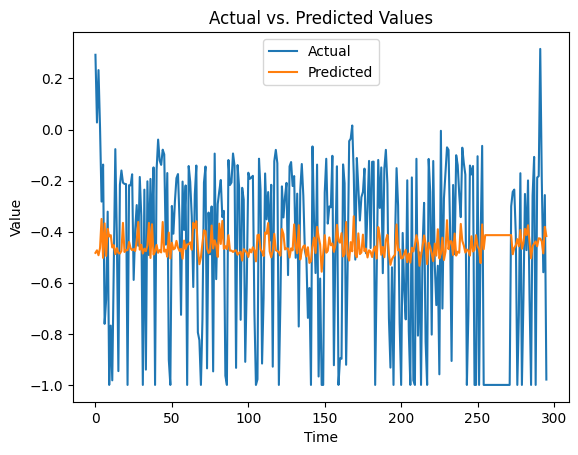

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 4 RMSE: 0.32249007964292337
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step


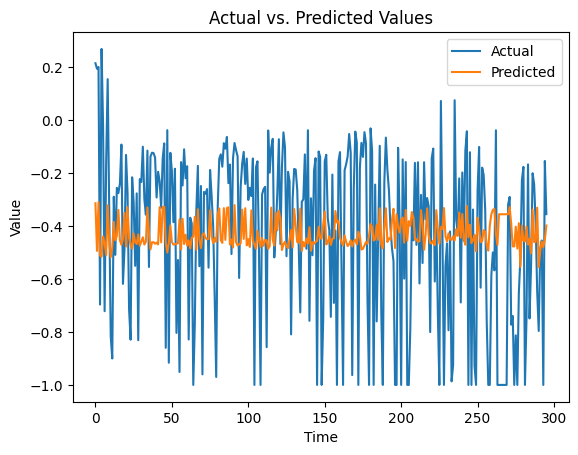

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 5 RMSE: 0.3477105852155326
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


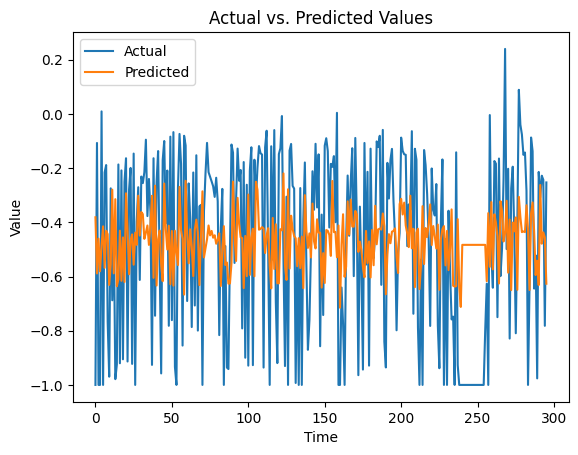

Average RMSE across all folds: 0.3528419756618631


In [291]:
avg_rmse, rmse_scores, training_histories = train_and_evaluate_model(df)

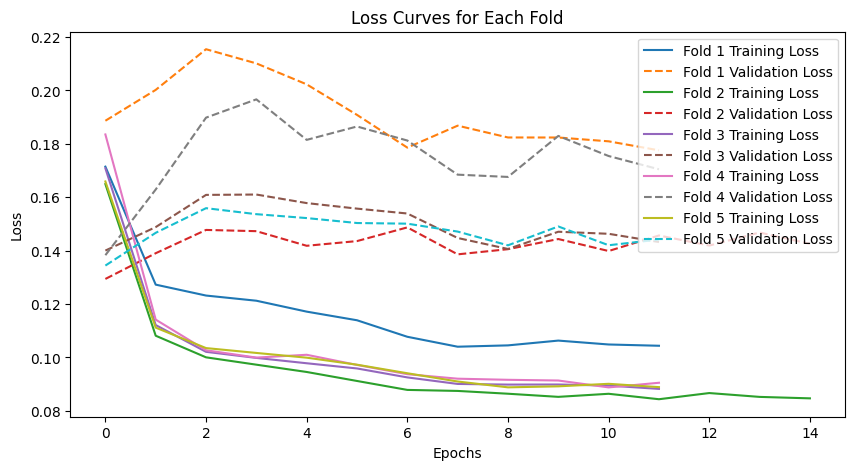

In [191]:
# Plot the loss curves for each fold
def plot_loss_curves(training_histories):
    plt.figure(figsize=(10, 5))  
    for i, history in enumerate(training_histories, 1):
        plt.plot(history.history['loss'], label=f'Fold {i} Training Loss')
        plt.plot(history.history['val_loss'], label=f'Fold {i} Validation Loss', linestyle='--')
    
    plt.title('Loss Curves for Each Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    
    plt.show()
    
plot_loss_curves(training_histories)

Consistent behavior across folds, where both the training and validation loss decrease steadily and converge to similar values, suggests that the model is learning effectively and generalizing well across different subsets of the data.


In [39]:
# Prepare input data for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Convert df to a NumPy array
dataset = df.values

# Define time step
time_step = 1

# Create the dataset
dataX, dataY = create_dataset(dataset, time_step)

# Combine dataX and dataY using np.concatenate
data_combined = np.concatenate((dataX, dataY.reshape(-1, 1)), axis=1)

# Define column names
column_names = [f't-{i}' for i in range(time_step, 0, -1)] + ['t']

# Create DataFrame
supervised = pd.DataFrame(data_combined, columns=column_names)

# Print the first 20 rows of the supervised dataset
print(supervised.head(20))

           t-1           t
0   129.124763  397.525094
1   397.525094  179.953536
2   179.953536   19.276294
3    19.276294  614.867925
4   614.867925  634.526163
5   634.526163  622.920089
6   622.920089  620.701784
7   620.701784  217.900209
8   217.900209    0.000000
9     0.000000    8.329495
10    8.329495  623.825204
11  623.825204  675.961407
12  675.961407  627.127364
13  627.127364  609.668061
14  609.668061  537.310311
15  537.310311  158.531217
16  158.531217    0.000000
17    0.000000  428.838854
18  428.838854  662.796954
19  662.796954  601.596282


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - MeanSquaredError: 0.2302 - loss: 0.2302 - val_MeanSquaredError: 0.3011 - val_loss: 0.3011
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1334 - loss: 0.1334 - val_MeanSquaredError: 0.1588 - val_loss: 0.1588
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1206 - loss: 0.1206 - val_MeanSquaredError: 0.1674 - val_loss: 0.1674
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1151 - loss: 0.1151 - val_MeanSquaredError: 0.1653 - val_loss: 0.1653
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1141 - loss: 0.1141 - val_MeanSquaredError: 0.1692 - val_loss: 0.1692
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1201 - loss: 0.1201 - val_MeanSquaredError: 0.1696 - val_loss: 0.1696
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1154 - loss: 0.1154 - val_MeanSquaredError: 0.1714 - val_loss: 0.1714
10/10 

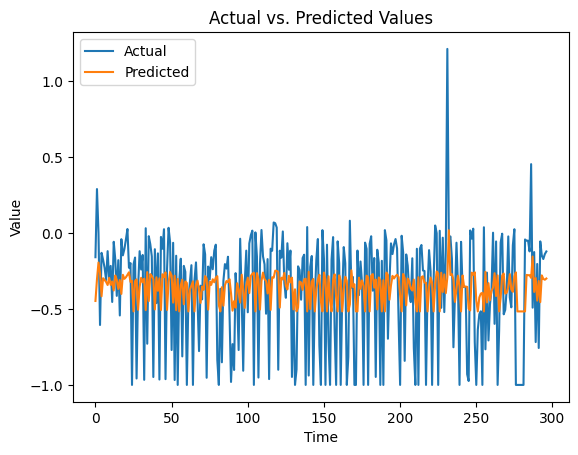

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - MeanSquaredError: 0.2545 - loss: 0.2545 - val_MeanSquaredError: 0.2856 - val_loss: 0.2856
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1361 - loss: 0.1361 - val_MeanSquaredError: 0.1162 - val_loss: 0.1162
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0968 - loss: 0.0968 - val_MeanSquaredError: 0.1247 - val_loss: 0.1247
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0937 - loss: 0.0937 - val_MeanSquaredError: 0.1217 - val_loss: 0.1217
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0967 - loss: 0.0967 - val_MeanSquaredError: 0.1239 - val_loss: 0.1239
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0956 - loss: 0.0956 - val_MeanSquaredError: 0.1213 - val_loss: 0.1213
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1013 - loss: 0.1013 - val_MeanSquaredError: 0.1251 - val_loss: 0.1251
10/10 

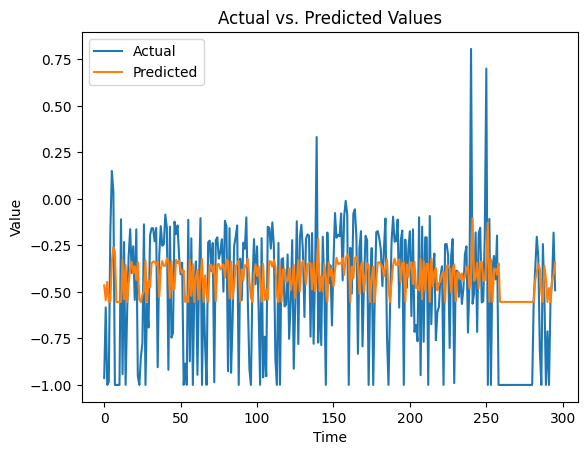

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - MeanSquaredError: 0.2656 - loss: 0.2656 - val_MeanSquaredError: 0.2737 - val_loss: 0.2737
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1295 - loss: 0.1295 - val_MeanSquaredError: 0.1221 - val_loss: 0.1221
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1091 - loss: 0.1091 - val_MeanSquaredError: 0.1361 - val_loss: 0.1361
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0908 - loss: 0.0908 - val_MeanSquaredError: 0.1266 - val_loss: 0.1266
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0997 - loss: 0.0997 - val_MeanSquaredError: 0.1338 - val_loss: 0.1338
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0954 - loss: 0.0954 - val_MeanSquaredError: 0.1315 - val_loss: 0.1315
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1032 - loss: 0.1032 - val_MeanSquaredError: 0.1332 - val_loss: 0.1332
10/10 

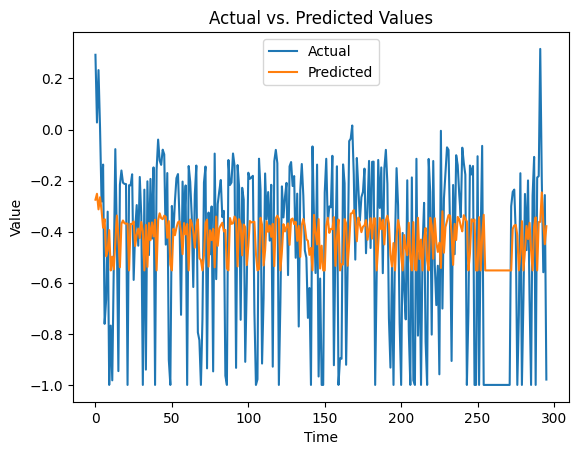

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - MeanSquaredError: 0.2593 - loss: 0.2593 - val_MeanSquaredError: 0.2714 - val_loss: 0.2714
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1343 - loss: 0.1343 - val_MeanSquaredError: 0.1211 - val_loss: 0.1211
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1073 - loss: 0.1073 - val_MeanSquaredError: 0.1332 - val_loss: 0.1332
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0991 - loss: 0.0991 - val_MeanSquaredError: 0.1342 - val_loss: 0.1342
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1006 - loss: 0.1006 - val_MeanSquaredError: 0.1339 - val_loss: 0.1339
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0970 - loss: 0.0970 - val_MeanSquaredError: 0.1349 - val_loss: 0.1349
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0961 - loss: 0.0961 - val_MeanSquaredError: 0.1416 - val_loss: 0.1416
10/10 

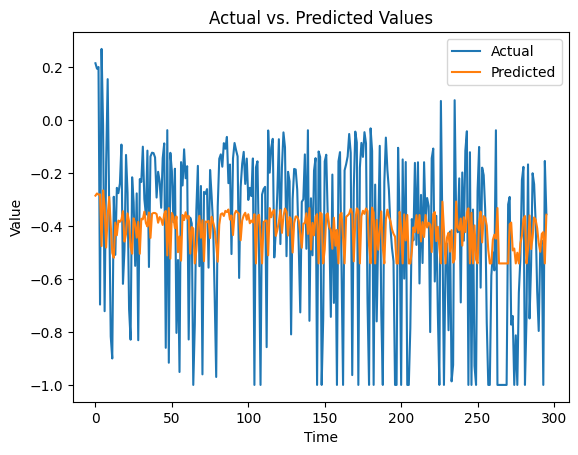

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - MeanSquaredError: 0.2600 - loss: 0.2600 - val_MeanSquaredError: 0.2741 - val_loss: 0.2741
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1316 - loss: 0.1316 - val_MeanSquaredError: 0.1225 - val_loss: 0.1225
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0958 - loss: 0.0958 - val_MeanSquaredError: 0.1342 - val_loss: 0.1342
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0893 - loss: 0.0893 - val_MeanSquaredError: 0.1297 - val_loss: 0.1297
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.1006 - loss: 0.1006 - val_MeanSquaredError: 0.1329 - val_loss: 0.1329
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0978 - loss: 0.0978 - val_MeanSquaredError: 0.1339 - val_loss: 0.1339
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - MeanSquaredError: 0.0957 - loss: 0.0957 - val_MeanSquaredError: 0.1290 - val_loss: 0.1290
10/10 

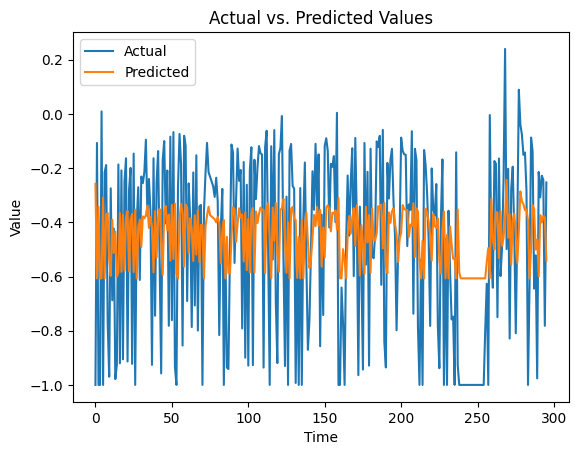

Average RMSE across all folds: 0.3480310310161713


In [53]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import os
import random
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


# Initialize parameters
n_layers = 2 # Number of LSTM layers
n_neurons = 50  # Number of LSTM units
dropout_rate = 0.2  # Dropout rate for regularization and prevent overfitting
time_step = 1  # Number of time steps in input sequence
learning_rate = 0.001  # Learning rate for optimization
num_epochs = 50  # Number of training epochs
batch_size = 32  # Batch size for training
features=1
active_fun= 'tanh'


name = f'{n_layers}_layers_{n_neurons}_neurons'


def train_and_evaluate_model(name,
                             n_layers,
                             n_neurons,
                             time_step,
                             features,
                             learning_rate,
                             dropout_rate,
                             num_epochs,
                             batch_size):
    # Set a seed to avoid different results due to randomization
    random.seed(1234)
    
    # creates a directory named results and then creates a subdirectory within results name specified by the variable name.
    Path('results/' + name).mkdir(parents=True, exist_ok=True)
    

    # Initialize time series cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=40) 
    
    # Initialize list to store RMSE values for each fold
    rmse_scores = []
    
    # Initialize list to store training history for each fold
    training_histories = []
    

    # Iterate over each fold
    for fold_idx, (train_index, test_index) in enumerate(kf.split(df), start=1):
        
        train_data = df.iloc[train_index].values
        test_data = df.iloc[test_index].values
        
        # Scale the data
        scaler = MinMaxScaler(feature_range=(-1, 1))
        train_data_scaled = scaler.fit_transform(train_data)
        test_data_scaled = scaler.transform(test_data)
        
        # Prepare input data for LSTM
        X_train, y_train = create_dataset(train_data_scaled, time_step)
        X_test, y_test = create_dataset(test_data_scaled, time_step)
        
        # Reshape input data for LSTM
        X_train = np.reshape(X_train, (X_train.shape[0], time_step, features))
        X_test = np.reshape(X_test, (X_test.shape[0], time_step, features))
        

        # Define EarlyStopping callback
        callback = keras.callbacks.EarlyStopping(monitor='val_MeanSquaredError', mode='min', min_delta = 0.01, patience = 5)


        # define lstm model
        model = Sequential()
        if n_layers == 1:
           model.add(LSTM(n_neurons, input_shape=(1, time_step), activation=active_fun,return_sequences=False))# this Step LSTM model. one LSTM after the other
        elif n_layers == 2:
             model.add(LSTM(n_neurons, input_shape=(1, time_step), activation=active_fun, return_sequences=True))
             model.add(LSTM(n_neurons, return_sequences=False))
        else:
             model.add(LSTM(n_neurons, input_shape=(1, time_step), activation=active_fun, return_sequences=True))
             for i in range(2, n_layers):
                 model.add(LSTM(n_neurons, input_shape=(1, time_step),activation=active_fun, return_sequences=True))
             model.add(LSTM(n_neurons,activation=active_fun, return_sequences=False))
        
        model.add(Dropout(dropout_rate))
        model.add(Dense(1)) # Output layer
        
       
        # Compile the model with the specified optimizer
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanSquaredError'])
       
        
        #Train the model
        history = model.fit(X_train, y_train, epochs=num_epochs, validation_split=0.2,callbacks=[callback])
        training_histories.append(history)
        
        # Evaluate the model
        testPredict = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test,testPredict))
        
        # append rmse score to the list serially 
        rmse_scores.append(rmse) 
        print(f"Fold {fold_idx} RMSE: {rmse}")
        
        # Assuming y_test contains the actual values and y_pred contains the predicted values
        # Plot the actual values
        plt.plot(y_test, label='Actual')

        # Plot the predicted values
        plt.plot(model.predict(X_test), label='Predicted')

        # Add labels and title
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Actual vs. Predicted Values')
        plt.legend()

        # Show plot
        plt.show()
    
    # Compute and print the average RMSE across all folds
    average_rmse = np.mean(rmse_scores)
    print(f"Average RMSE across all folds: {average_rmse}")
    
    # save average root mean square error
    np.savetxt('results/' + name + '/results.csv', [average_rmse], delimiter=',')

    return (average_rmse, rmse_scores, training_histories)
    
    
average_rmse, rmse_scores, training_histories = train_and_evaluate_model(n_layers=n_layers, n_neurons=n_neurons, time_step=time_step, features=features, learning_rate=learning_rate, dropout_rate=dropout_rate, num_epochs=num_epochs, batch_size=batch_size, name=name)

Plotting the loss curves for each fold in a cross-validation process provides insights into how the model's performance evolves during training across different folds of the dataset. Each fold represents a different subset of the data used for training and validation.

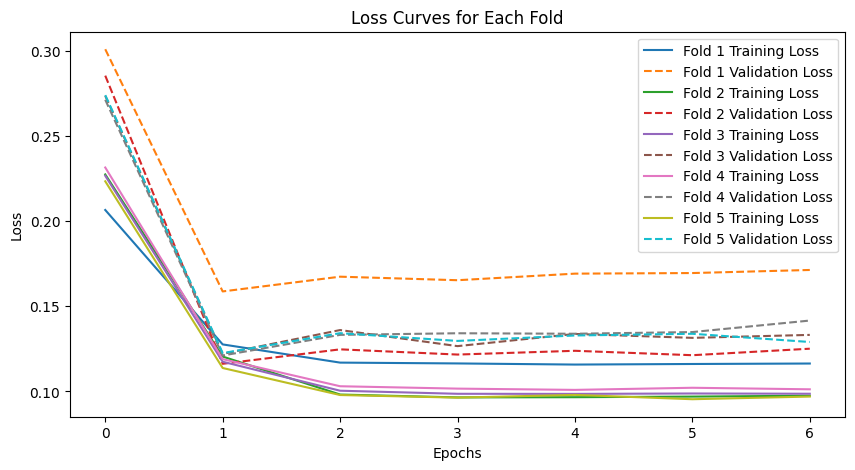

In [55]:
# Plot the loss curves for each fold
def plot_loss_curves(training_histories):
    plt.figure(figsize=(10, 5))  
    for i, history in enumerate(training_histories, 1):
        plt.plot(history.history['loss'], label=f'Fold {i} Training Loss')
        plt.plot(history.history['val_loss'], label=f'Fold {i} Validation Loss', linestyle='--')
    
    plt.title('Loss Curves for Each Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
   
plot_loss_curves(training_histories)


Consistent behavior across folds, where both the training and validation loss decrease steadily and converge to similar values, suggests that the model is learning effectively and generalizing well across different subsets of the data.


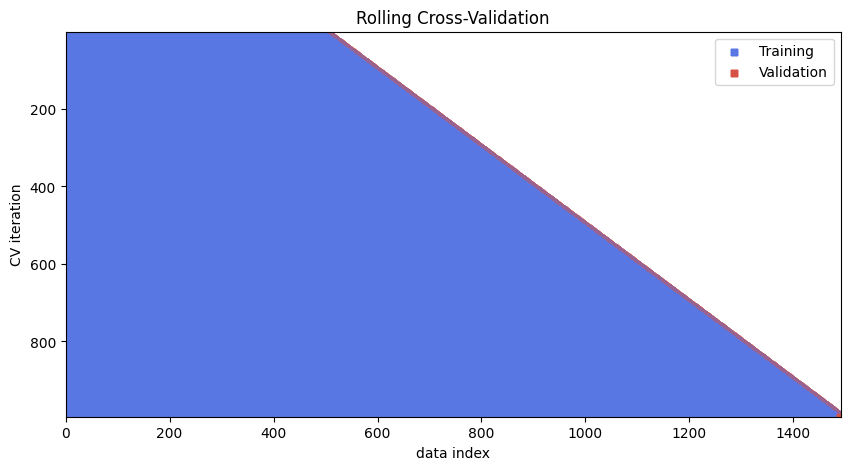

In [41]:
# the cross-validation procedure based on a rolling forecasting origin 
# Readin the data set kepping date as index
df = pd.read_csv("weighted_sum.csv")
df=pd.DataFrame(df)
initial_train_size = len(df) // 3  # Use the first third for initial training
n_splits = len(df) - initial_train_size  # Number of one-step forecasts

# Visualization setup
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(n_splits):
    train_end = initial_train_size + i
    test_end = train_end + 1

    train = df.iloc[:train_end]
    test = df.iloc[train_end:test_end]

    # Plot training and test indices with transparency
    l1 = ax.scatter(train.index, [i + 1] * len(train.index), c=[plt.cm.coolwarm(0.1)],
                    marker='+', lw=5)
    l2 = ax.scatter(test.index, [i + 1] * len(test.index), c=[plt.cm.coolwarm(0.9)],
                    marker='+', lw=5)


# Set axis limits and labels
ax.set(ylim=[n_splits + 0.3,0.7],xlim=[0,len(df)], title='Rolling Cross-Validation', xlabel='data index', ylabel='CV iteration')

ax.legend([l1, l2], ['Training', 'Validation'])
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 1 RMSE: 0.44911887834854014
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


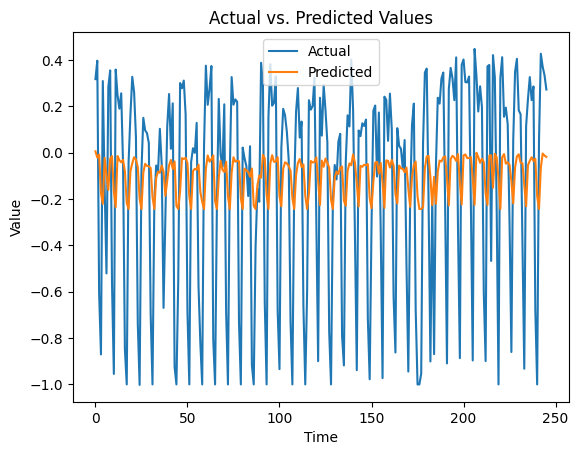

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 2 RMSE: 0.4487892349170516
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step


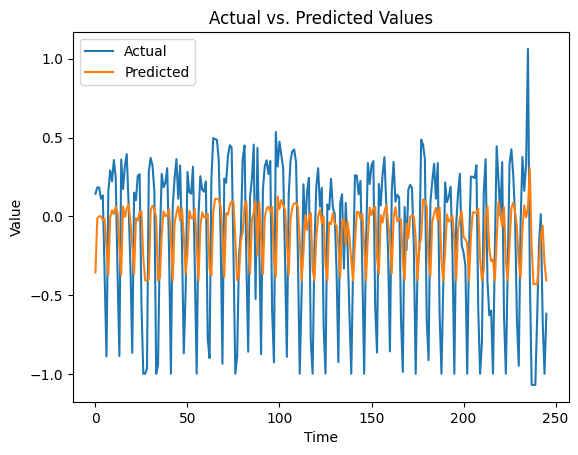

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 3 RMSE: 0.4259450198507331
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step


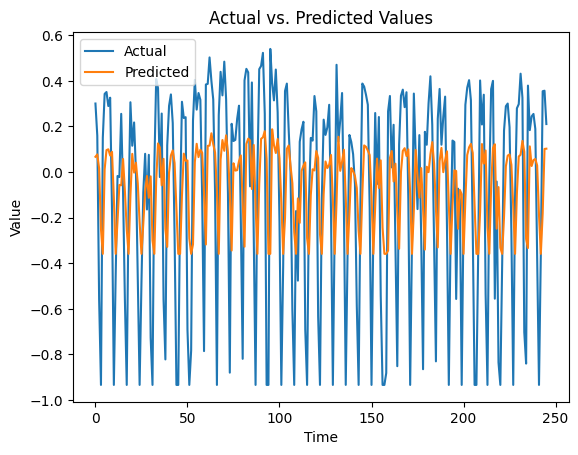

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Fold 4 RMSE: 0.46229626099400867
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


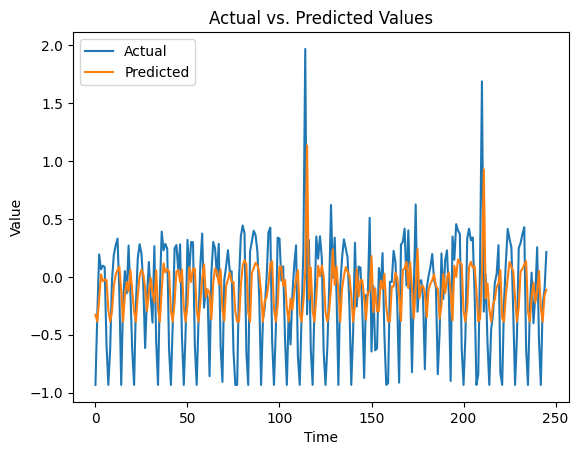

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Fold 5 RMSE: 0.33235847272208835
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


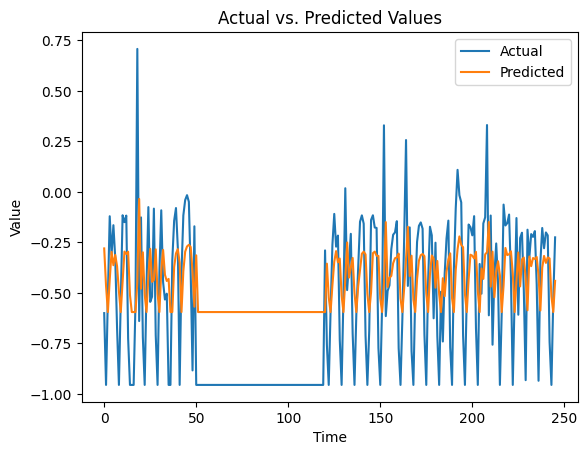

Average RMSE across all folds: 0.4237015733664844


ValueError: too many values to unpack (expected 3)